In [2]:
import os
import cv2
import torch
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import albumentations as A
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

# Define the UNet model
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):  # num_classes = 1 for binary segmentation
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.middle = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        m = self.middle(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(m), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.out_conv(d1)

Processing: train_data/v3/S1001L02.jpg


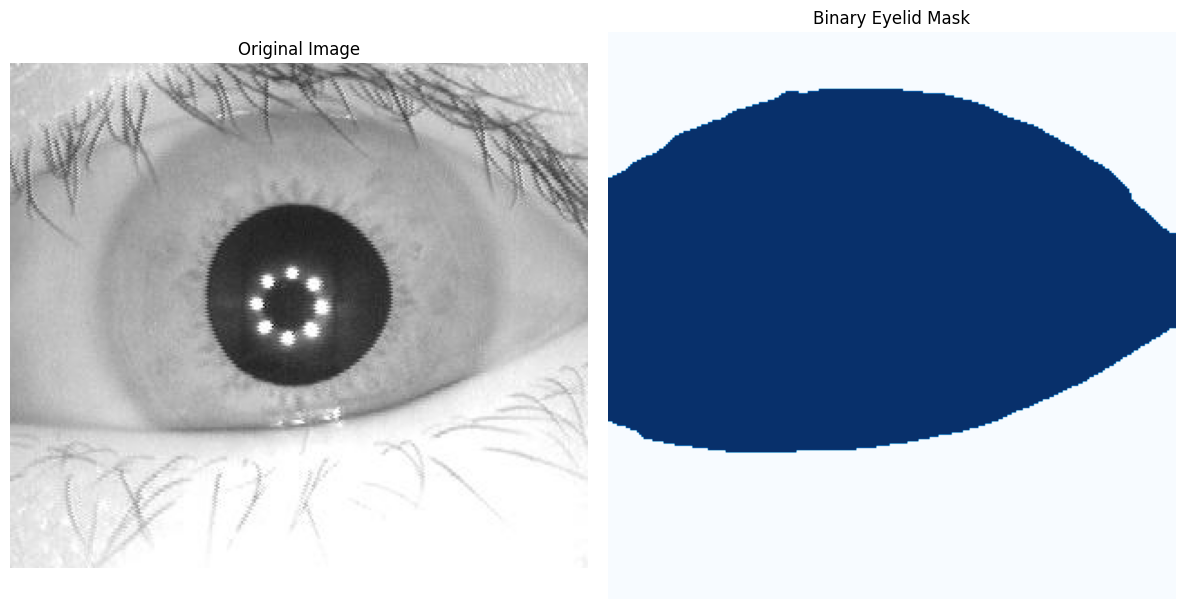

Processing: train_data/v3/S1001L04.jpg


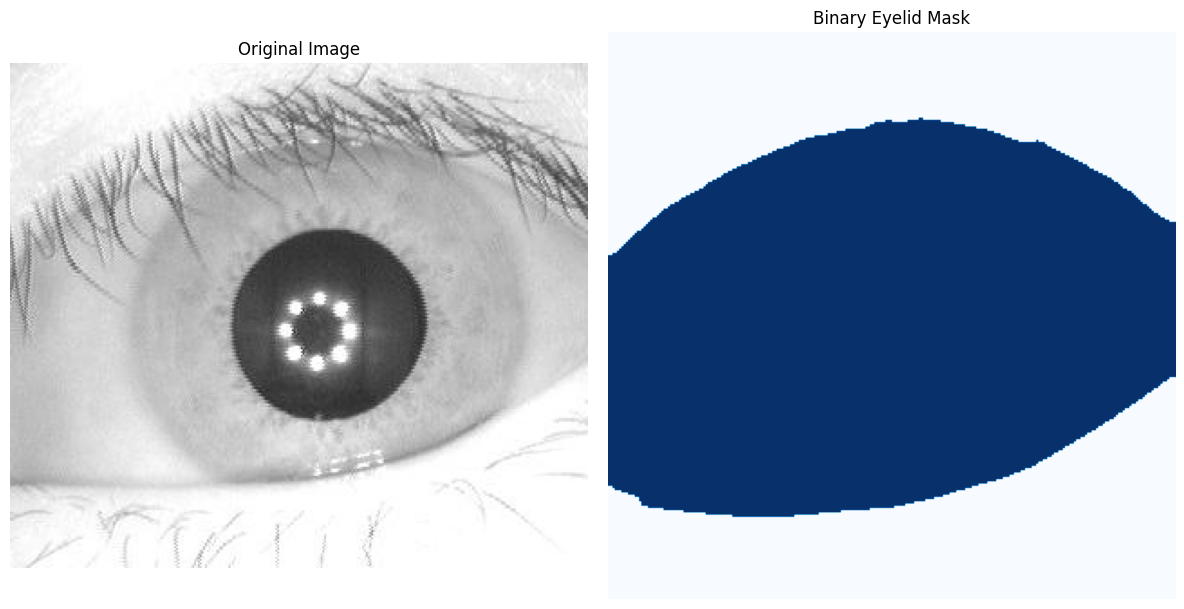

Processing: train_data/v3/S1001L03.jpg


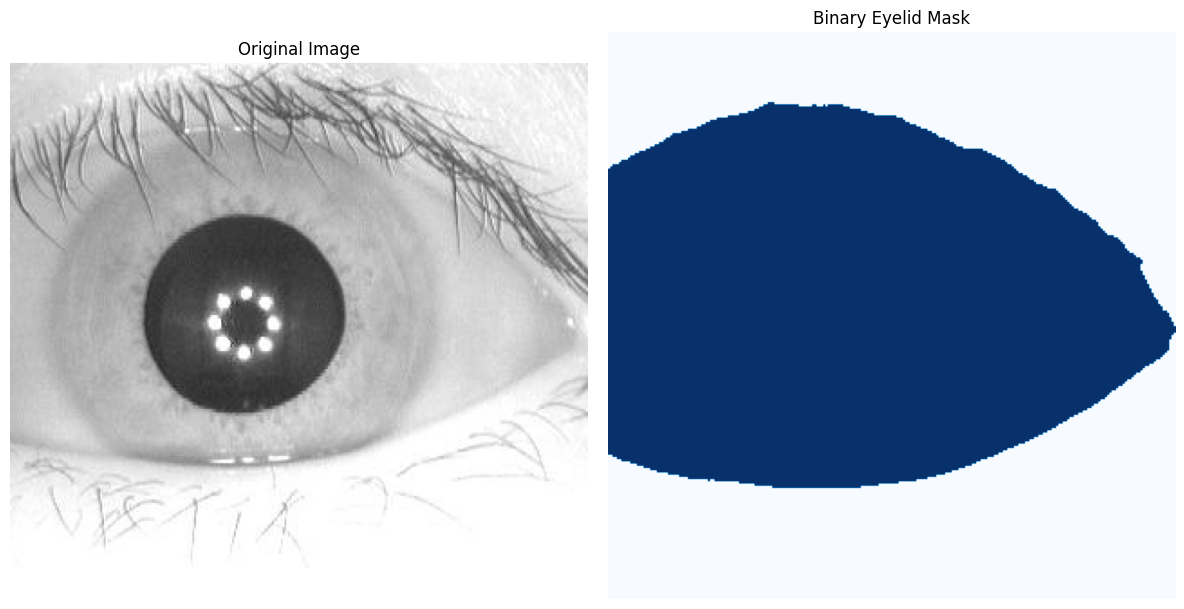

Processing: train_data/v3/S1001L06.jpg


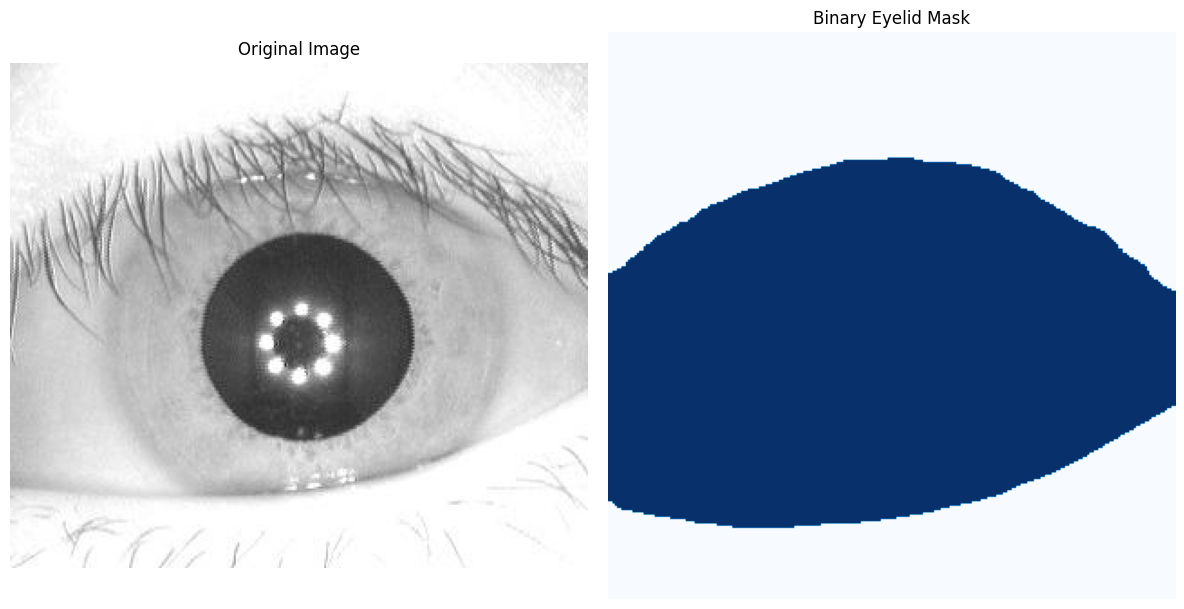

Processing: train_data/v3/S1001L05.jpg


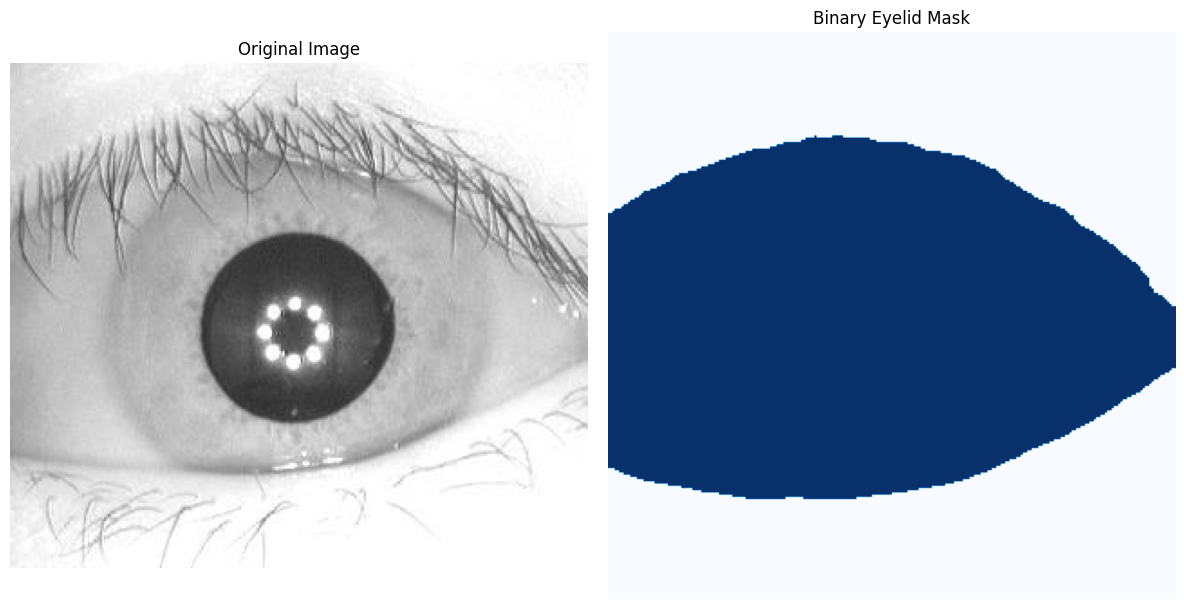

Processing: train_data/v3/S1001L07.jpg


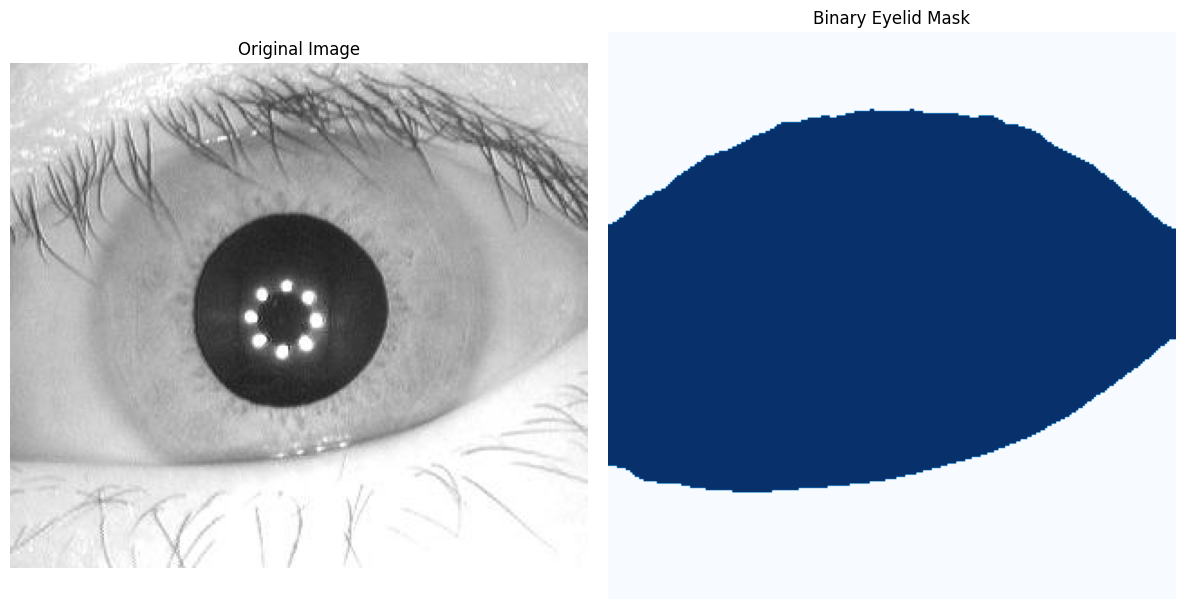

Processing: train_data/v3/S1001L08.jpg


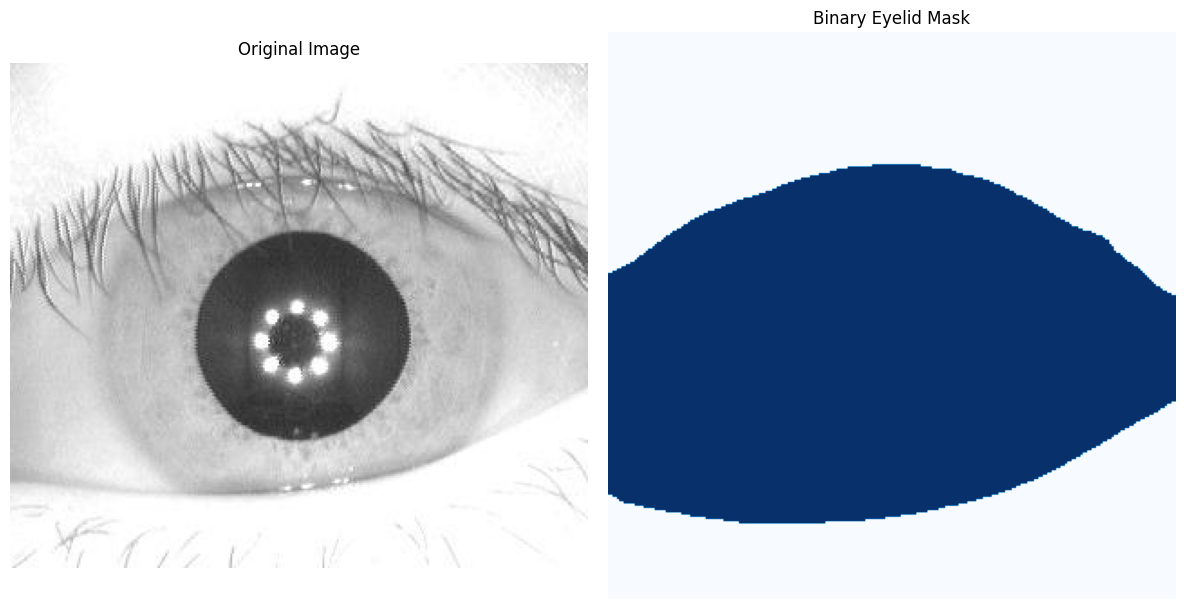

Processing: train_data/v3/S1001L09.jpg


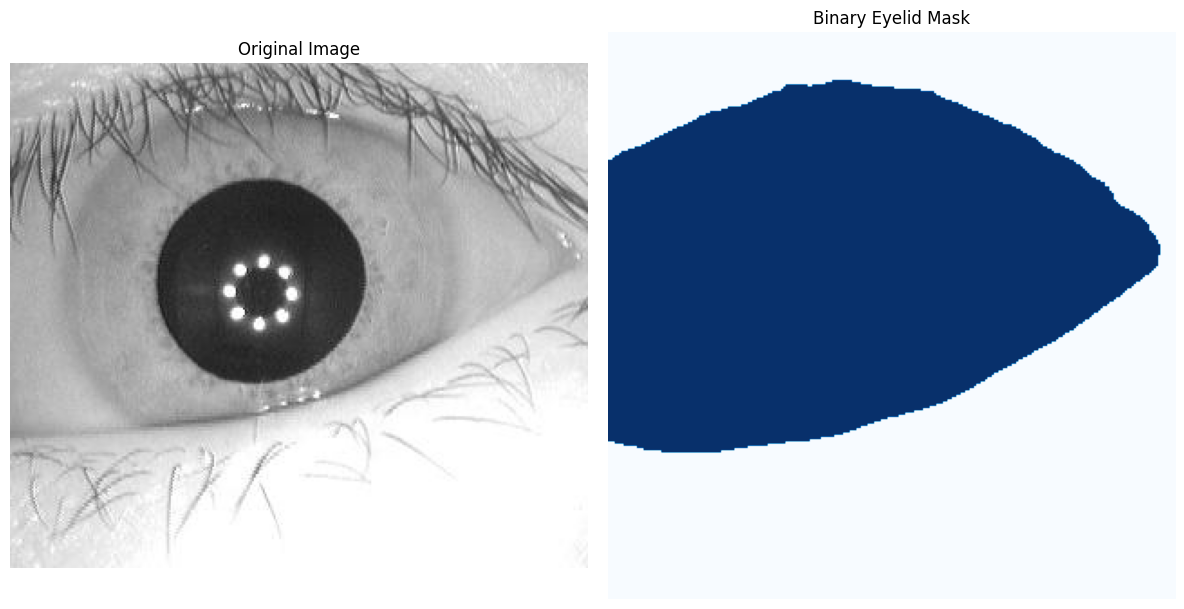

Processing: train_data/v3/S1001L10.jpg


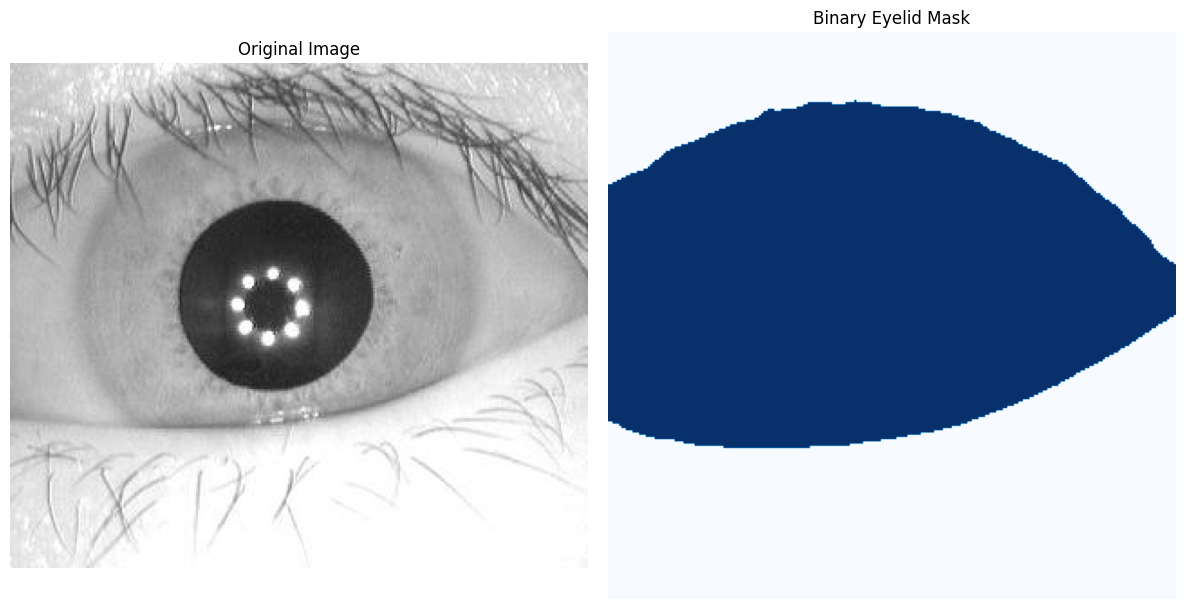

Processing: train_data/v3/S1001R01.jpg


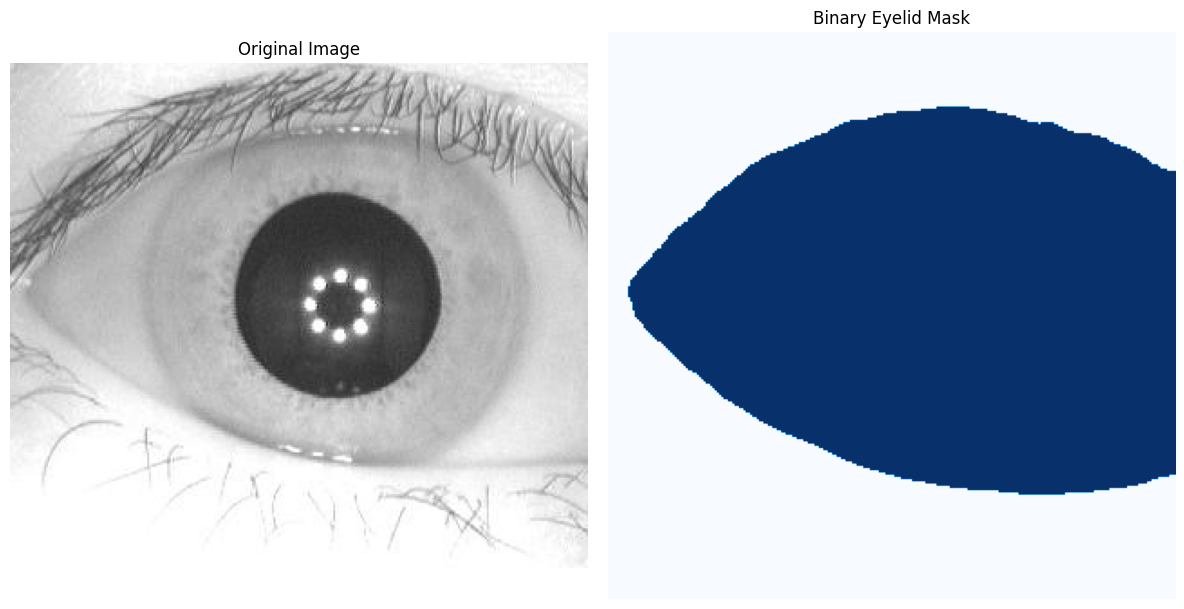

Processing: train_data/v3/S1001R02.jpg


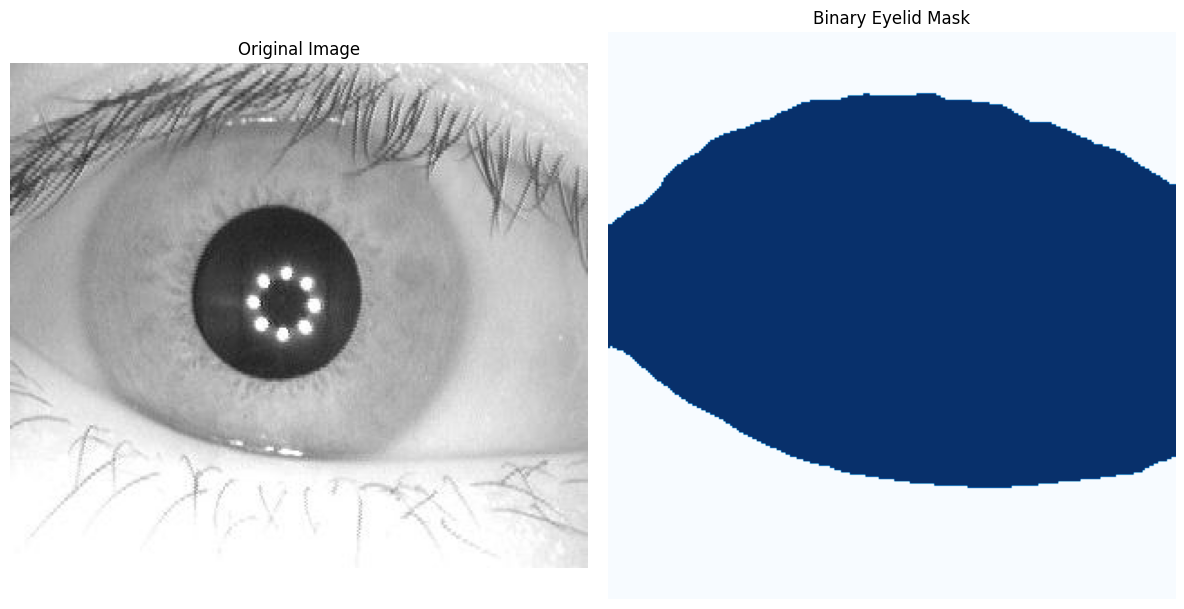

Processing: train_data/v3/S1001R03.jpg


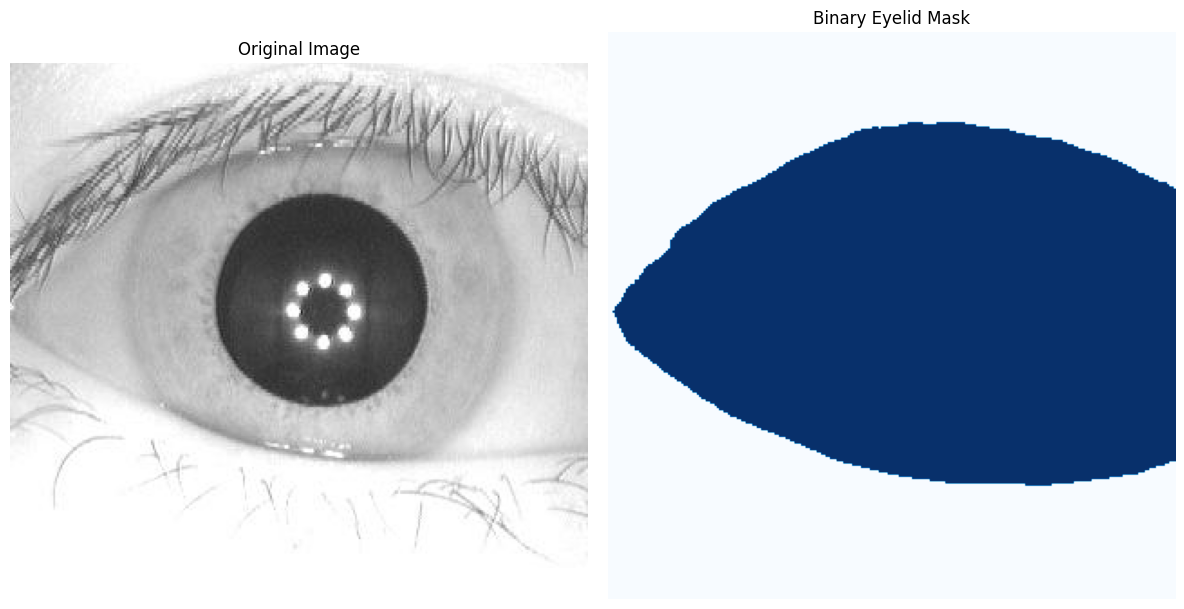

Processing: train_data/v3/S1001R04.jpg


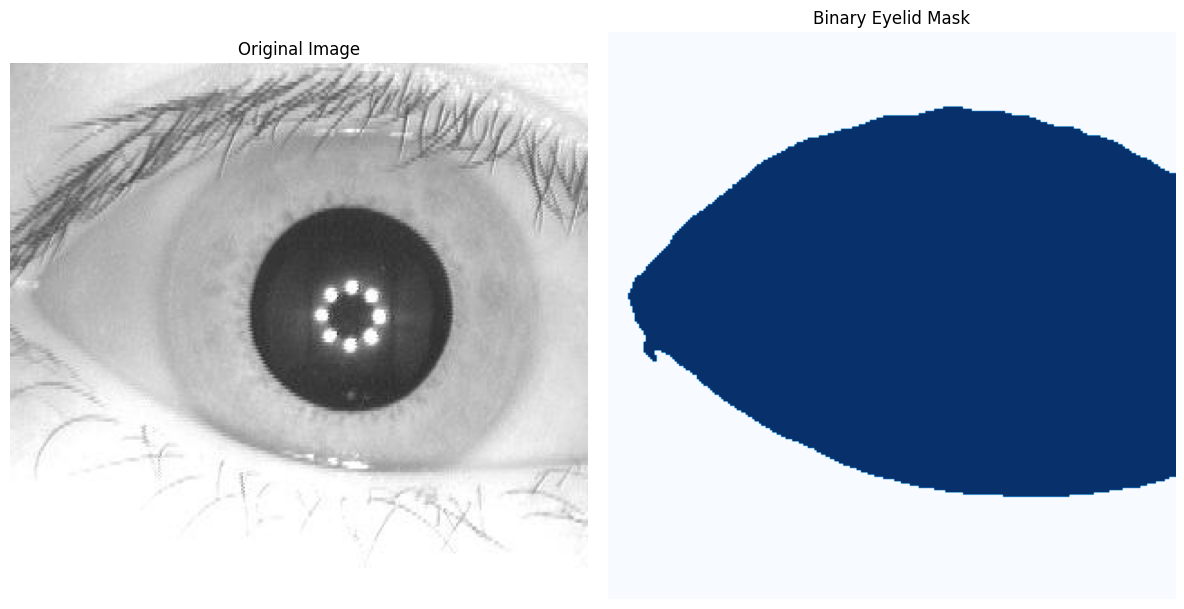

Processing: train_data/v3/S1001R05.jpg


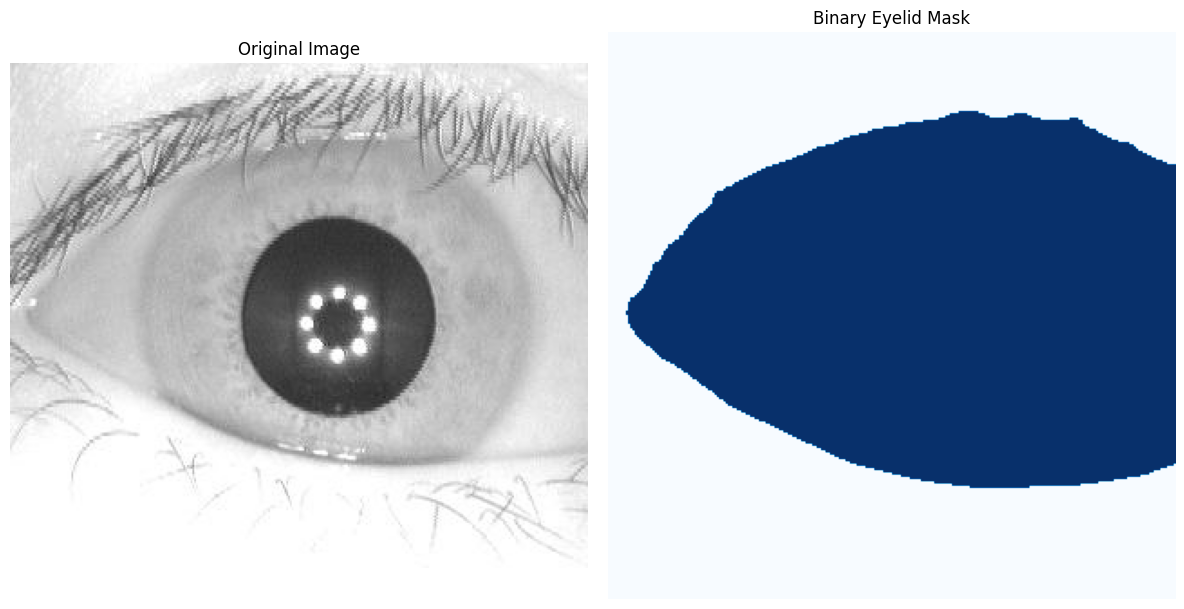

Processing: train_data/v3/S1001R06.jpg


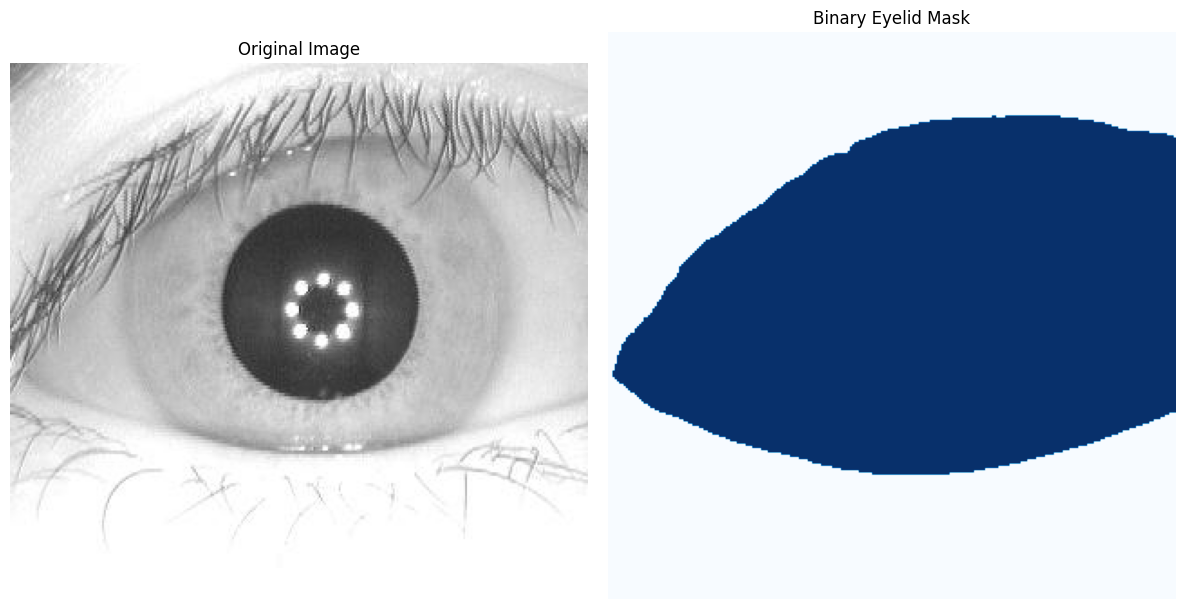

Processing: train_data/v3/S1001R07.jpg


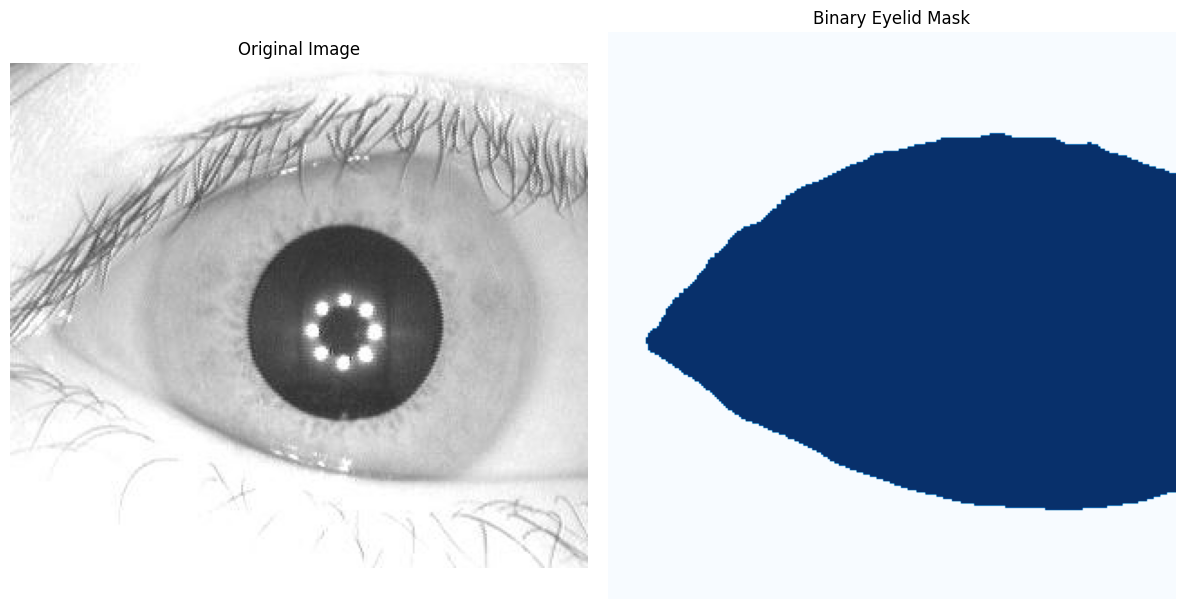

Processing: train_data/v3/S1001R08.jpg


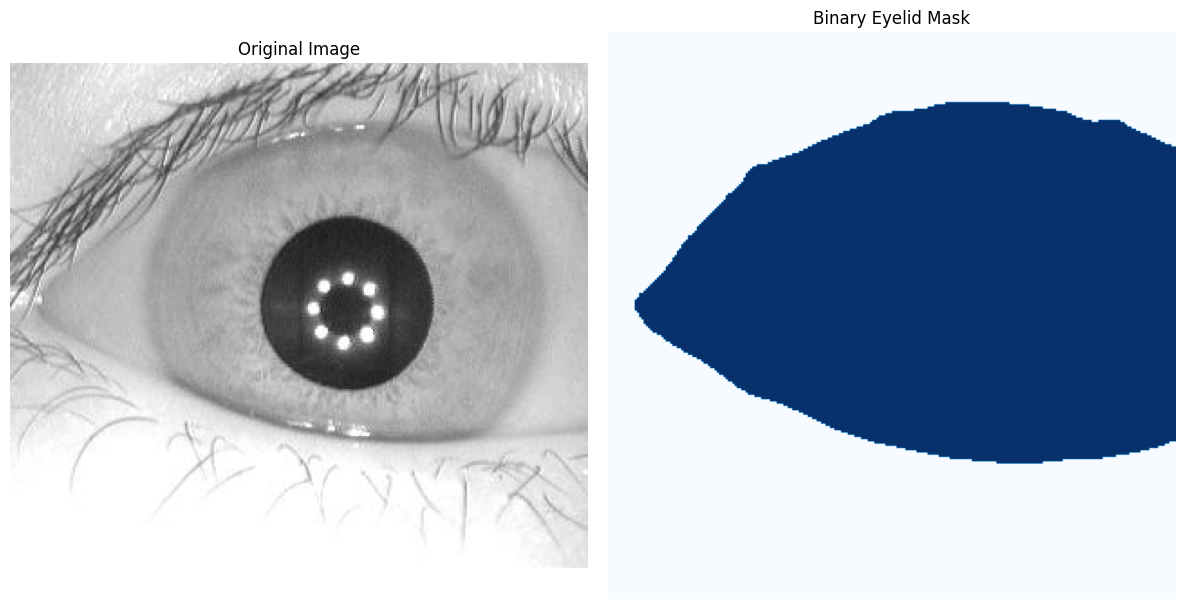

Processing: train_data/v3/S1001R09.jpg


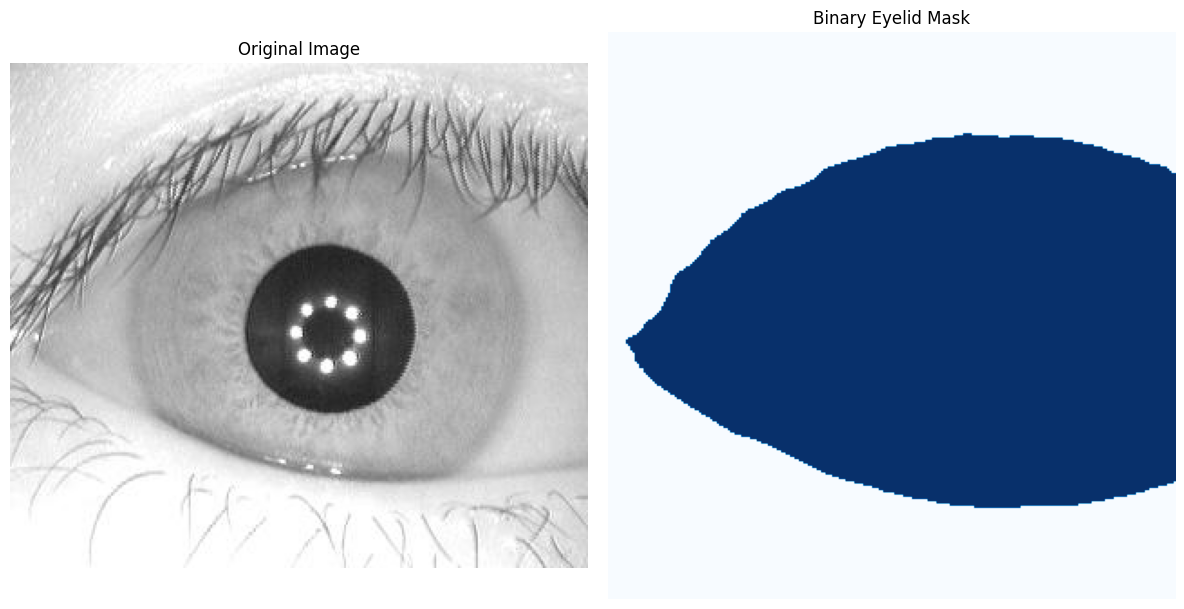

Processing: train_data/v3/S1001R10.jpg


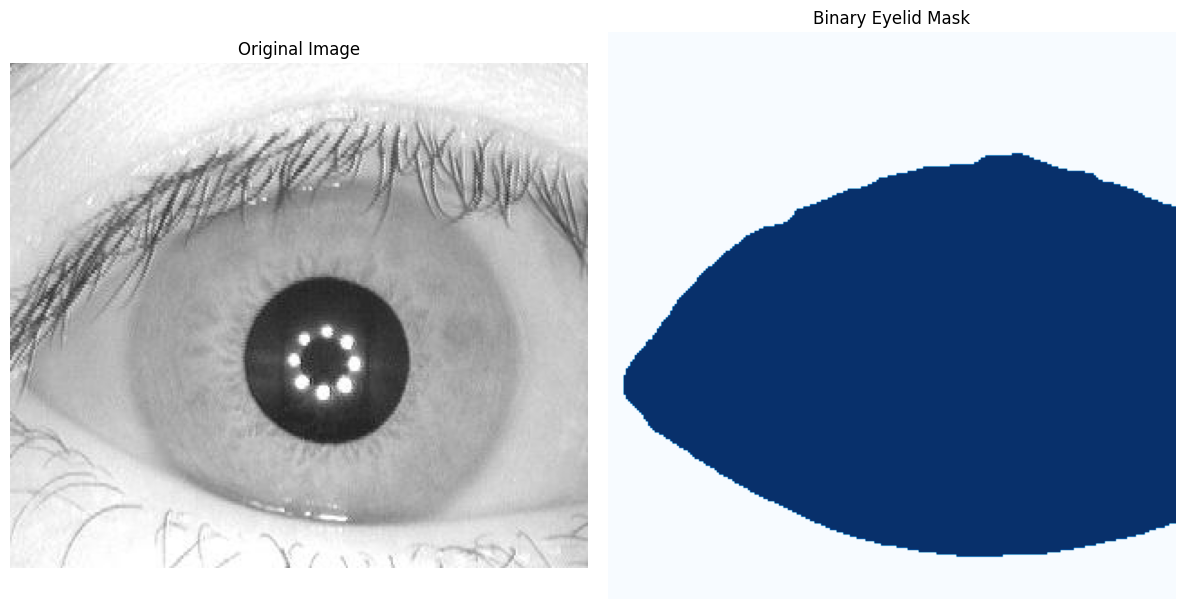

Processing: train_data/v3/S1002L01.jpg


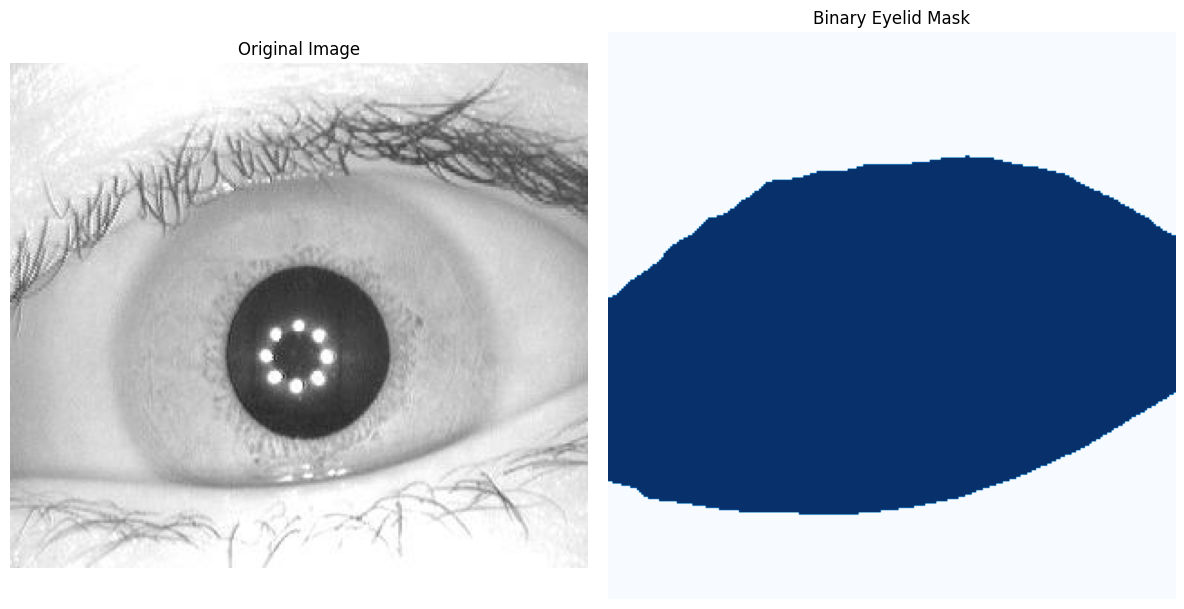

Processing: train_data/v3/S1002L02.jpg


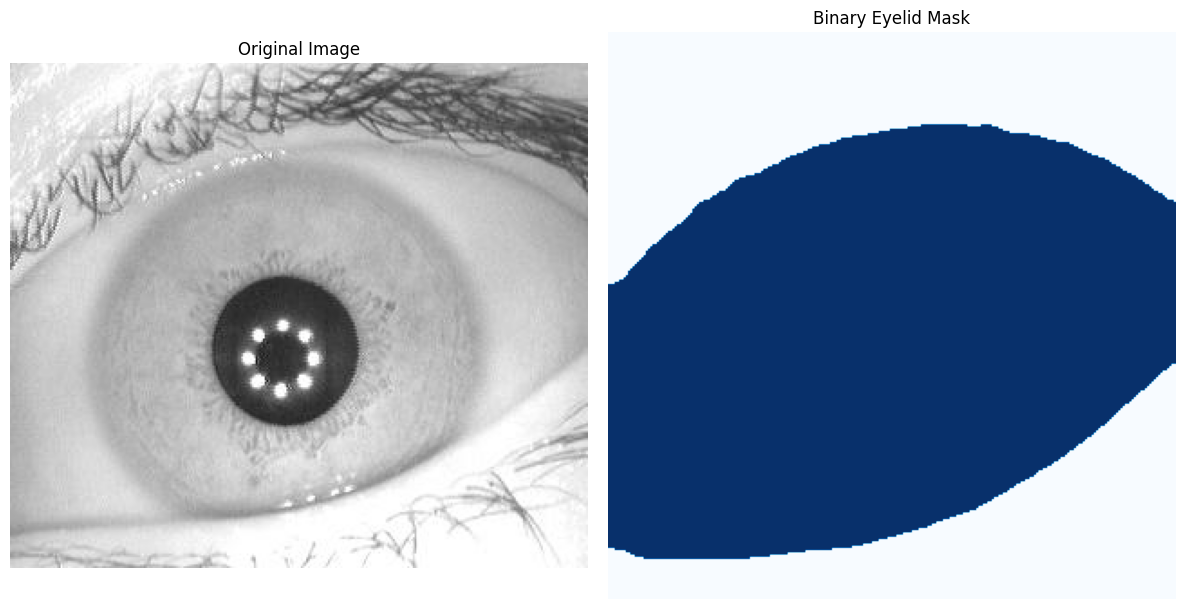

Processing: train_data/v3/S1002L03.jpg


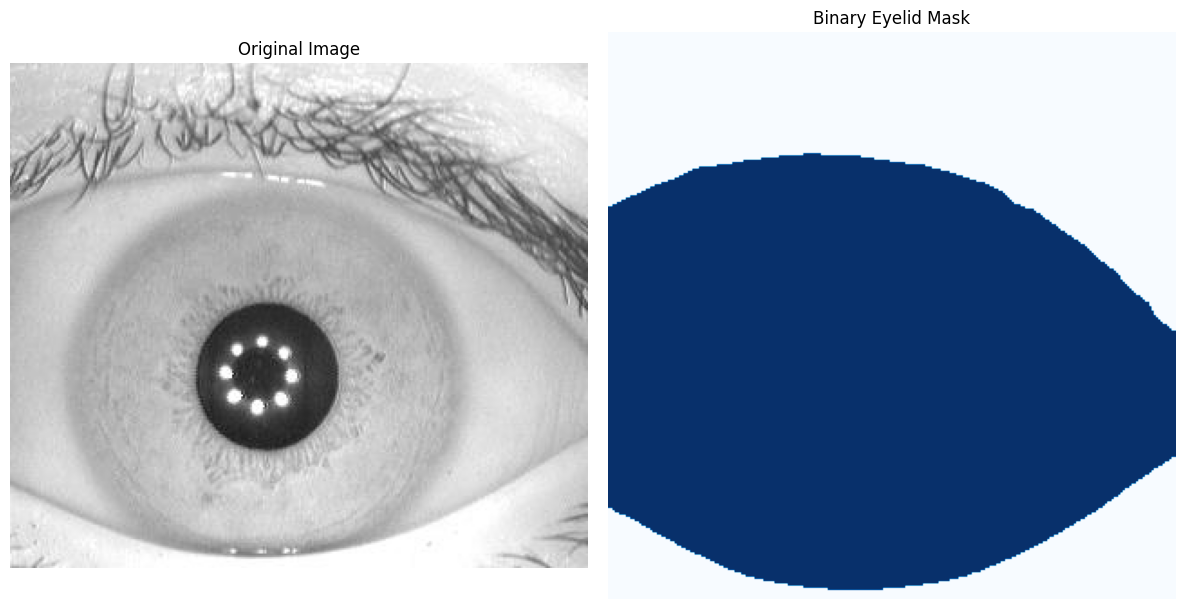

Processing: train_data/v3/S1002L04.jpg


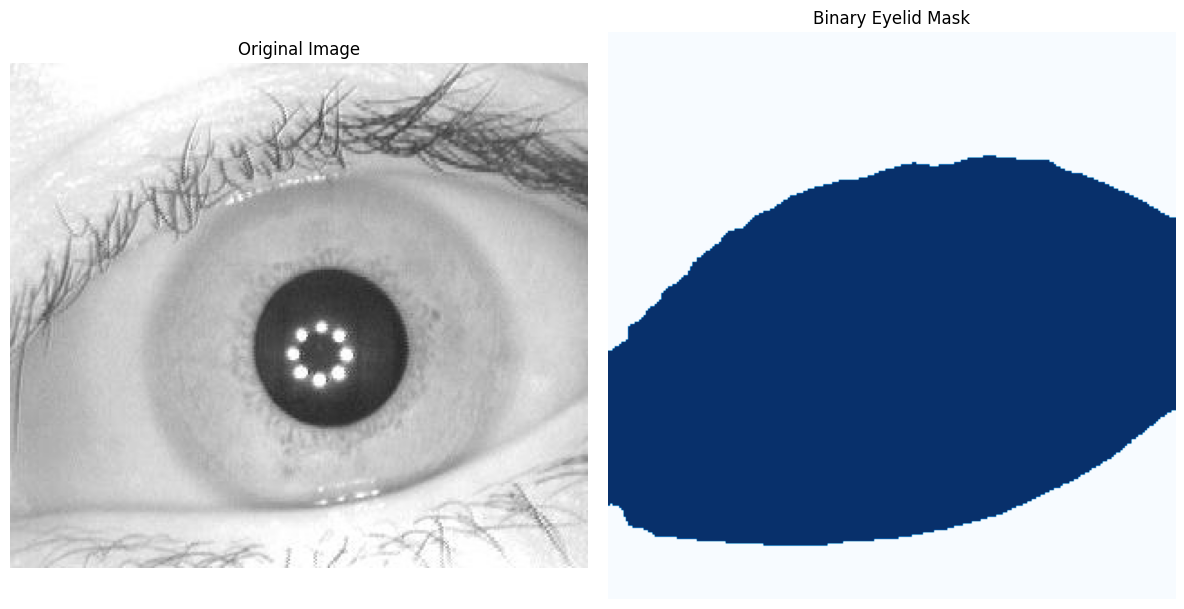

Processing: train_data/v3/S1002L05.jpg


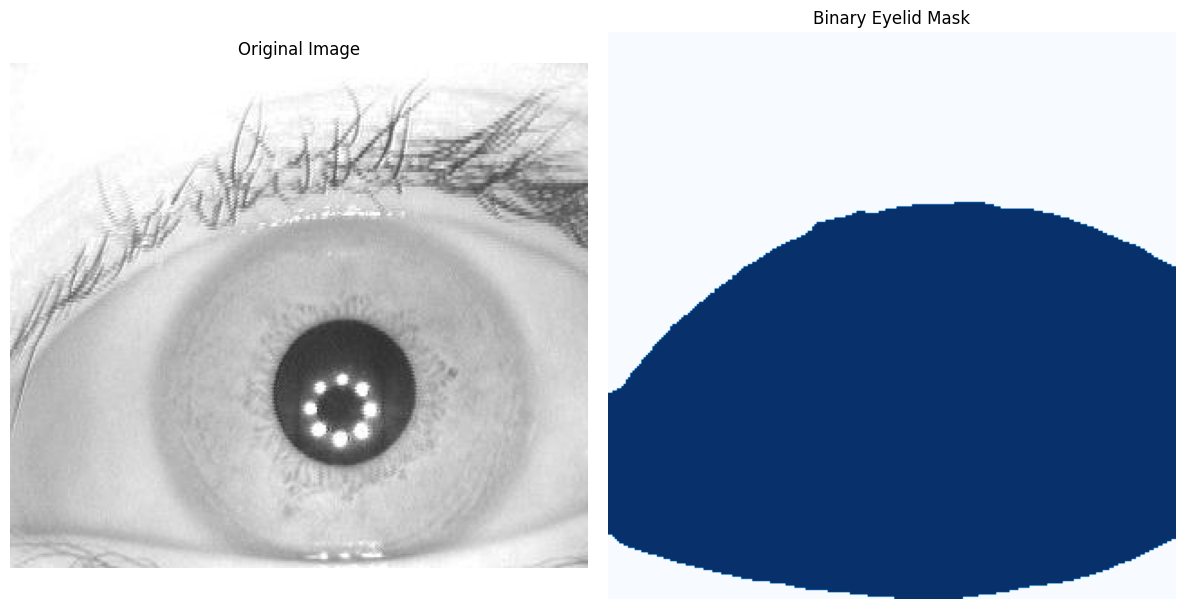

Processing: train_data/v3/S1002L06.jpg


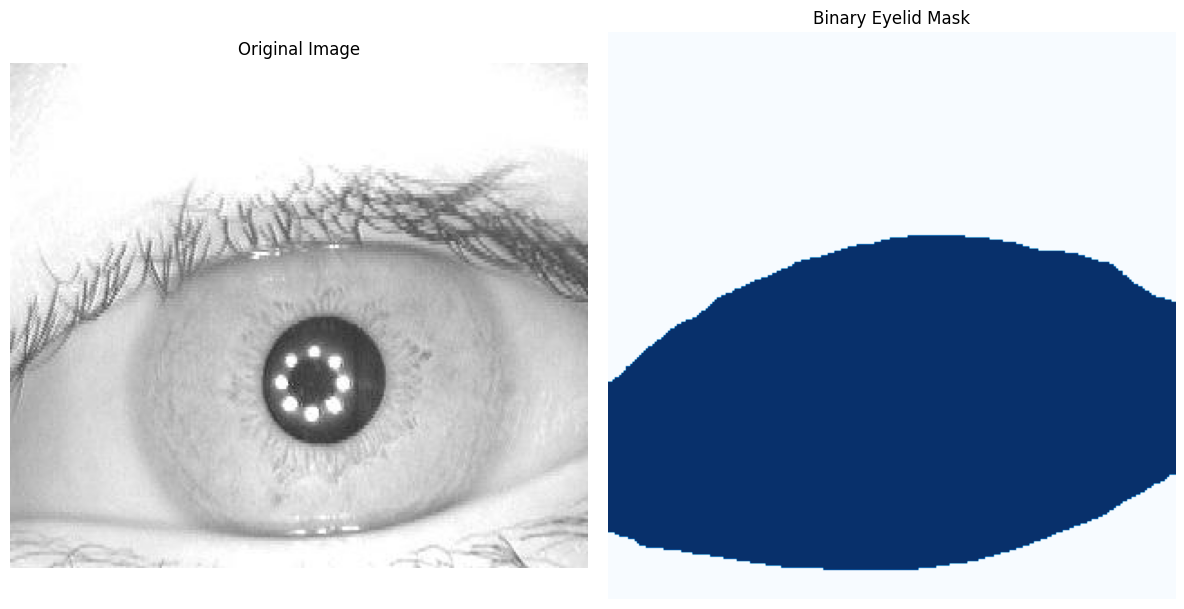

In [4]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision import transforms

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, num_classes=1).to(device)
model.load_state_dict(torch.load('eyelid_only.pth'))
model.eval()  # Set the model to evaluation mode

# Function to preprocess the input image
def preprocess_image(image_path, img_size=(256, 256)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, img_size)  # Resize image to match model input size

    # Normalize the image (similar to training)
    img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
    return img_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Function to predict eyelid mask
def predict_eyelid_mask(image_path):
    img_tensor = preprocess_image(image_path)

    with torch.no_grad():  # Disable gradient calculation during inference
        output = model(img_tensor)  # Forward pass through the model
        output = torch.sigmoid(output)  # Apply sigmoid to get probabilities
        mask = (output.squeeze(0) > 0.5).cpu().numpy()  # Threshold to get binary mask

    return mask

# Function to visualize the original image and the binary mask side by side
def visualize_comparison(image_path, mask):
    # Load and preprocess the original image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization

    # Squeeze the extra dimension (if it exists) to get a 2D mask
    mask = mask.squeeze()  # This will change shape from (1, 256, 256) to (256, 256)

    # Create the plot for original image and binary mask side by side
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    # Predicted binary mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='Blues')  # Display the binary mask using 'Blues' colormap
    plt.title("Binary Eyelid Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Function to process a specified number of images from a folder
def process_images_in_folder(folder_path, num_images=None):
    # Get all image file paths in the folder
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Limit the number of images processed if specified
    if num_images is not None:
        image_paths = image_paths[:num_images]  # Slice to get the specified number of images

    # Process each image
    for image_path in image_paths:
        print(f"Processing: {image_path}")
        mask = predict_eyelid_mask(image_path)
        visualize_comparison(image_path, mask)  # Show original image next to the binary mask

# Example usage
folder_path = 'train_data/v3'  # Replace with your folder path
num_images_to_process = 25  # Specify the number of images to process (set to None for all images)
process_images_in_folder(folder_path, num_images=num_images_to_process)
